In [2]:
from functools import partial
import os
import argparse
import yaml

import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from guided_diffusion.blind_condition_methods import get_conditioning_method
from guided_diffusion.measurements import get_operator, get_noise

# Here replaces the regular unet by our trained unet
# from guided_diffusion.unet import create_model
import guided_diffusion.diffusion_model_unet 
import guided_diffusion.unet

from guided_diffusion.gaussian_diffusion import create_sampler
from data.dataloader import get_dataset, get_dataloader
from motionblur.motionblur import Kernel
from util.img_utils import Blurkernel, clear_color
from util.logger import get_logger
from skimage.restoration import richardson_lucy, wiener, unsupervised_wiener
from mpl_toolkits.axes_grid1 import make_axes_locatable

device = 'cpu'
    
name = 'ellipse'
root = './data/ellipse_samples/'

transform = transforms.Compose([transforms.ToTensor()])
dataset = get_dataset(name=name, root=root, transforms=transform)
loader = get_dataloader(dataset, batch_size=1, num_workers=0, train=False)

# set seed for reproduce
np.random.seed(123)

def mlem(x_0_hat, steps, **kwargs):
    img = x_0_hat['img']
    kernel = x_0_hat['kernel']
    
    deconv_img = richardson_lucy(img.numpy(), kernel.numpy(), num_iter=steps, clip=False, filter_epsilon=1e-3)
    
    x_0_hat['img'] = torch.from_numpy(deconv_img).to(device)
    
    return x_0_hat

def wiener_deconv(x_0_hat, steps, **kwargs):
    img = x_0_hat['img']
    kernel = x_0_hat['kernel']
    
    deconv_img = wiener(image=img.numpy(), balance=1.0, psf=kernel.numpy(), clip=False)
    # deconv_img, _ = unsupervised_wiener(image=img.numpy(), psf=kernel.numpy(), clip=False)
    
    x_0_hat['img'] = torch.from_numpy(deconv_img).to(device)
    
    return x_0_hat

/home/modrzyk/code/blind-dps/guided_diffusion/measurements.py:176: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  b_img = F.conv2d(data[:, 0, :, :], kernel, padding='same')


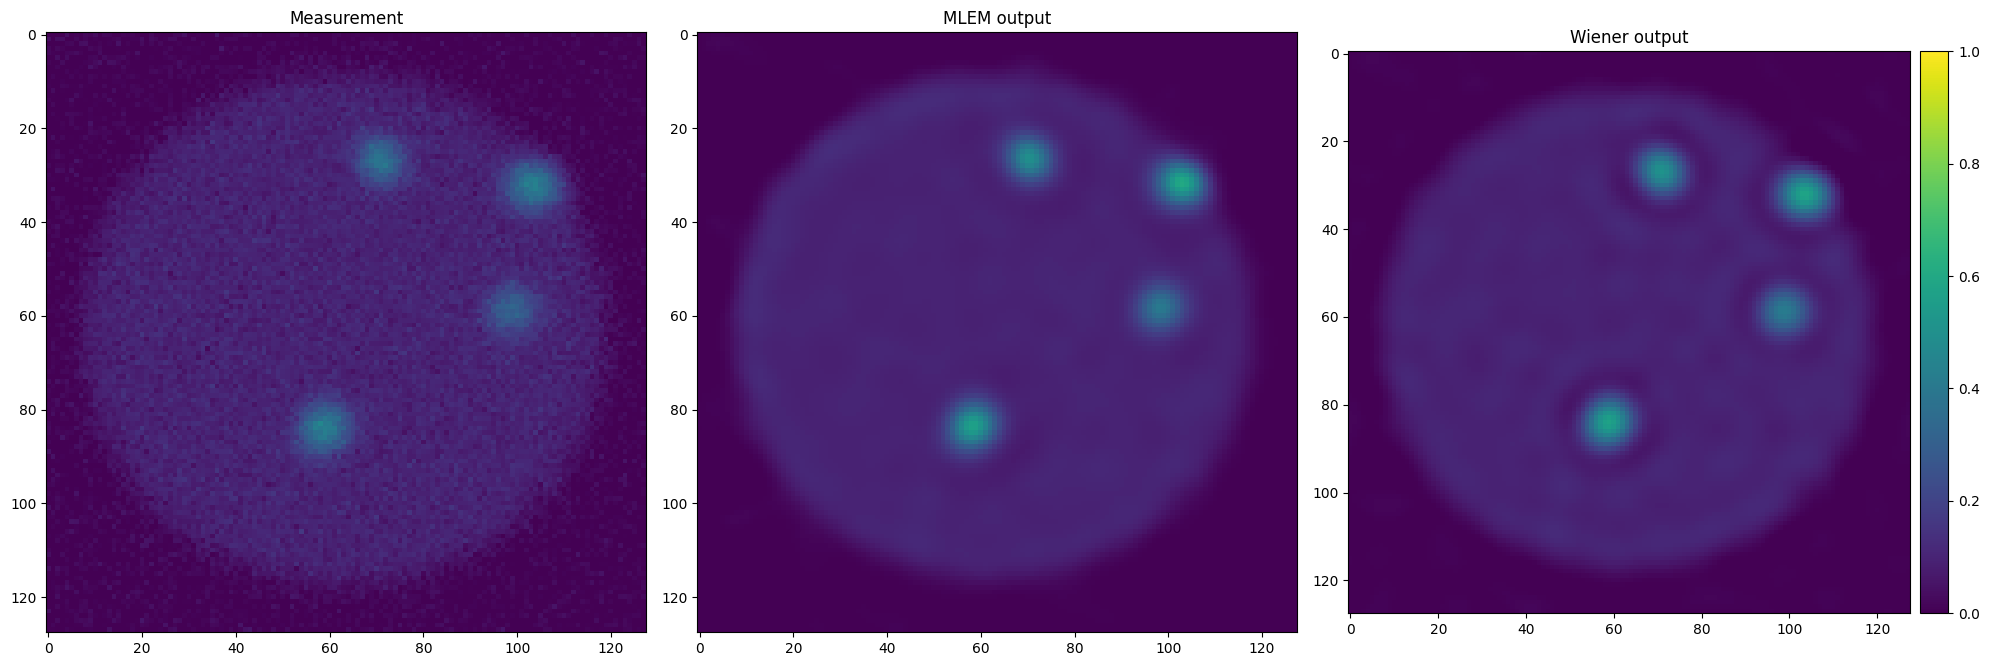

In [3]:
kernel_size = 64
kernel_std = 3.0
noise_level = 0.02

operator = get_operator(name='blind_blur', device=device)
noiser = get_noise(name='gaussian', sigma=noise_level)

# Do Inference
for i, ref_img in enumerate(loader):
    
    conv = Blurkernel('gaussian', kernel_size=kernel_size, std=kernel_std, device=device)
    kernel = conv.get_kernel().type(torch.float32)
    kernel = kernel.to(device).view(1, 1, kernel_size, kernel_size)

    ref_img = ref_img.to(device)
    y = operator.forward(ref_img, kernel)
    y = noiser(y)
    y = y.unsqueeze(0)
    
    y_mlem = y.clone()
    y_wiener = y.clone()
    
    y_mlem = y_mlem.squeeze()
    y_wiener = y_wiener.squeeze()
    kernel = kernel.squeeze()
    
    steps = 4
    
    # Call mlem
    x_0_hat_mlem = mlem(x_0_hat={'img': y_mlem, 'kernel': kernel}, steps=steps)
    
    # Call wiener
    x_0_hat_wiener = wiener_deconv(x_0_hat={'img': y_wiener, 'kernel': kernel}, steps=steps)

    # Create a figure and adjust the layout
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    # Display y
    ax1 = axes[0]
    im1 = ax1.imshow(y.squeeze().cpu().numpy(), vmin=0, vmax=1.0)
    ax1.set_title('Measurement')

    # Display y after MLEM
    ax2 = axes[1]
    im2 = ax2.imshow(x_0_hat_mlem['img'].squeeze().cpu().numpy(), vmin=0.0, vmax=1.0)
    ax2.set_title('MLEM output')

    # Display y after Wiener
    ax3 = axes[2]
    im3 = ax3.imshow(x_0_hat_wiener['img'].squeeze().cpu().numpy(), vmin=0.0, vmax=1.0)
    ax3.set_title('Wiener output')

    # Create a colorbar axis
    divider = make_axes_locatable(axes[2])  # Use the last axis (ax3) for colorbar
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Create a colorbar for all subplots
    cbar = fig.colorbar(im3, cax=cax)

    # Adjust the layout
    plt.tight_layout()
    plt.show()
    
    break
plt.show()